In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import gridspec
from matplotlib import colors

import os
import re
import numpy as np
import pandas as pd
import cooler

import itertools


In [4]:
import seaborn as sns

In [5]:
import bioframe
from bioframe.io import resources
from bioframe import io

In [6]:
# cooltools used dekkerlab-fork, develop-branch, commit-af508bba9c6577b8271b716ba27c330bead15981
from cooler.tools import split, partition
from functools import partial
from cooltools import expected

In [7]:
from helper_module import fillcolor_compartment_style, to_uscs, bar_signal, random_test, bar_path

In [8]:
from cooltools import numutils
from cooltools.eigdecomp import cooler_cis_eig

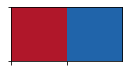

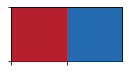

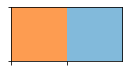

In [9]:
sns.palplot(sns.color_palette([(0.6922722029988466, 0.09227220299884659, 0.1677047289504037),(0.12725874663590928, 0.3958477508650519, 0.6687427912341407)]))
n_colors = 8
sns.palplot([sns.color_palette("RdBu", n_colors)[0],sns.color_palette("RdBu", n_colors)[-1]])
palet = [sns.color_palette("RdBu", n_colors)[0],sns.color_palette("RdBu", n_colors)[-1]]

sns.palplot([sns.color_palette("Oranges", n_colors)[-5],sns.color_palette("Blues", n_colors)[-5]])
palet2 = [sns.color_palette("Oranges", n_colors)[-5],sns.color_palette("Blues", n_colors)[-5]]

In [10]:
cooler_names = [
    'all-allele-spe-2percent-highcis.galGal5.mapq_30.1000.mcool',
#     'all-allele-spe-1percent-highcis.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
#     'MNP-DT40-1-3-16-R2-T1__galGal5.galGal5.mapq_30.1000.mcool',
    
    'MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
#     'MNP-DT40-1-3-17-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    
    'MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.1000.mcool']

### generate some nicer sample names from coolers ...

In [11]:
# multiqc learnings here, btw!...
renamings = {"all-allele-spe":"pool",
            ".galGal5.mapq_30.1000.mcool":"",
            "MNP-DT40-":"",
            "-T1__galGal5":"",
            "-R1":"",
            "1-3-":"clone-"}

sample_names = []
for c in cooler_names:
    for rf,rt in renamings.items():
        c = re.sub(rf,rt,c)
    sample_names.append(c)

# sample_names

# form a df of samples here:
samples = pd.DataFrame({"sample":sample_names,"mcool":cooler_names})

samples

,sample,mcool
0,pool-2percent-highcis,all-allele-spe-2percent-highcis.galGal5.mapq_3...
1,clone-16-2p,MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq...
2,clone-17-2p,MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq...
3,WT1,MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.10...
4,WT2,MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.10...


In [12]:
# READ SOME COOLERS ...
binsize = 100_000

res_human = f"{int(binsize/1000)}kb"

# oldref-20200617
cool_path = "/home/venevs/DOTS_TESTING/alv-chicken/oldref-20200617"
get_cpath = lambda c,b: os.path.join(cool_path,c+f"::/resolutions/{b}")

samples["cool"] = [cooler.Cooler(get_cpath(c,binsize)) for c in samples["mcool"]]
samples["sum"] = [s.info["sum"] for s in samples["cool"]]

In [13]:
clr, = samples["cool"][samples["sample"] == "pool-2percent-highcis"].values
clr100, = samples["cool"][samples["sample"] == "pool-2percent-highcis"].values

chrom = "chr1"
parm = (chrom,0,74626886)
qarm = (chrom,75126886,196202544)
centro = (chrom,74626886,75126886)
balance = True

# bad_bins = None
ignore_diags = 2
theregion=parm
theregion_name="parm"

# prevent beta-actin promoter mismappings:
# (chrom,194_569_534,194_570_623)
bad_bin_regions = [(chrom,9_000_000,9_500_000),(chrom,32_270_000,32_770_000), (chrom,194_569_534,194_570_623)]
bad_bins = np.concatenate([np.arange(*clr.extent(_bb)) for _bb in bad_bin_regions])

locus_bin=72_500_000
ins_row = clr.offset((chrom,locus_bin,locus_bin+binsize))

weight_name = "weight"
weight1 = weight_name + "1"
weight2 = weight_name + "2"
transforms = {"balanced": lambda p: p["count"] * p[weight1] * p[weight2]}

### read replication timing to use as a phasing track (only `chr1` is available)

In [14]:
val_rt = io.read_table(
    "/home/venevs/DOTS_TESTING/alv-chicken/timing_wt.bed",
    schema="bedGraph",
    skiprows=1
)

bins = clr.bins().fetch(chrom).copy()

# overlap RT signal with our bins ...
binned_rt = bioframe.ops.overlap(bins, val_rt, suffixes=['', '_rt']) \
    .drop(labels=["chrom_rt","start_rt","end_rt","weight"],axis="columns") \
    .fillna(np.nan) # addressing pd.NA issue with this

# finally :
binned_rt = binned_rt \
    .groupby(["chrom","start","end"],observed=True,sort=False) \
    .mean() \
    .reset_index()

### compute compartments per arm masking bad bins ...

(0.0, 1963.0)

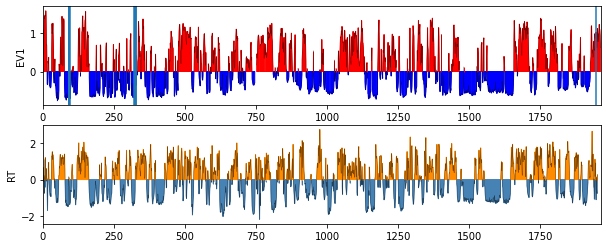

In [15]:
eigvals1, eigvec_table1 = cooler_cis_eig(
    clr=clr,
    bins=binned_rt,
    regions= [parm, qarm],
    n_eigs=2,
    bad_bins = bad_bins,
    phasing_track_col="value_rt",
    clip_percentile=99.9,
    sort_metric=None,
)

# plot it, just in case:
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(2,1,1)
axrt = f.add_subplot(2,1,2)
fillcolor_compartment_style(eigvec_table1["E1"], ax)
for bb in bad_bins:
    ax.axvline(bb)

fillcolor_compartment_style(binned_rt["value_rt"], axrt, color_less="steelblue", color_more="darkorange")

ax.set_ylabel("EV1")
axrt.set_ylabel("RT")
ax.set_xlim(*clr.extent(chrom))
axrt.set_xlim(*clr.extent(chrom))

### calculate expecteds the new way ...

#### Actually it seems that we shouldn't be changing the input cooler starting from here - otherwise the exepcted would not correspond to OBS, etc

In [16]:
# we could redefine cooler file here:
#  but after that it is fixed:
# clr = samples["cool"][0]
# samplez = "clone-16-2p" # pool-2percent-highcis
samplez = "pool-2percent-highcis"
clr, = samples["cool"][samples["sample"] == samplez].values

In [17]:
import multiprocess as mp

nproc = 4

# matching regions: p-arm        pq-inter arm            chr1-wide ...
left_regions  = [(*parm,'parm'),(*parm,'parm'),("chr1",0,clr.chromsizes["chr1"],"chr1")]
right_regions = [(*parm,'parm'),(*qarm,'qarm'),("chr1",0,clr.chromsizes["chr1"],"chr1")]
# execution details
if nproc > 1:
    pool = mp.Pool(nproc)
    
    map_ = pool.map
else:
    map_ = map

exp_df_bad = expected.diagsum_asymm(clr,
                 regions1 = left_regions,
                 regions2 = right_regions,
                 transforms=transforms,
                 weight_name='weight',
                 bad_bins=bad_bins,
                 map = map_)
exp_df_bad["balanced.avg"] = exp_df_bad["balanced.sum"]/exp_df_bad["n_valid"]
exp_grp_bad = exp_df_bad.groupby(["region1","region2"])
# extract several expecteds for different regions ...
parm_exp_bad = exp_grp_bad.get_group(("parm","parm"))
pqarm_exp_bad = exp_grp_bad.get_group(("parm","qarm"))
chr1_exp_bad = exp_grp_bad.get_group(("chr1","chr1"))


exp_df_bad_raw = expected.diagsum_asymm(clr,
                     regions1 = left_regions,
                     regions2 = right_regions,
                     transforms={},
                     weight_name=None,
                     bad_bins=bad_bins,
                     map = map_)
exp_df_bad_raw["count.avg"] = exp_df_bad_raw["count.sum"]/exp_df_bad_raw["n_valid"]
exp_df_bad_raw_grp = exp_df_bad_raw.groupby(["region1","region2"])
# extract several expecteds for different regions ...
parm_exp_bad_raw = exp_df_bad_raw_grp.get_group(("parm","parm"))
pqarm_exp_bad_raw = exp_df_bad_raw_grp.get_group(("parm","qarm"))
chr1_exp_bad_raw = exp_df_bad_raw_grp.get_group(("chr1","chr1"))


pool.close()


## now to allele1/2 ...

generating appropriate `expecteds` for p and q arms, for the insertion site

In [18]:
chr1_parm = to_uscs(parm)
chr1_qarm = to_uscs(qarm)
# shape of the inter-arm heatmap ...
lo,hi = clr.extent(parm)
psize = hi-lo
lo,hi = clr.extent(qarm)
qsize = hi-lo
shape = (psize,qsize)
print(shape)

# this function that 1D exepcted to rectangular - for pq-expected
get_cr = lambda e, shape : (e[shape[0]-1::-1], e[shape[0]-1:])

# balanced expecteds ...
pqexp = numutils.LazyToeplitz(*get_cr(pqarm_exp_bad["balanced.avg"].values, shape))
pexp = numutils.LazyToeplitz(parm_exp_bad["balanced.avg"])
chr1exp = numutils.LazyToeplitz(chr1_exp_bad["balanced.avg"])

# raw expecteds ...
pqexp_raw = numutils.LazyToeplitz(*get_cr(pqarm_exp_bad_raw["count.avg"].values, shape))
pexp_raw = numutils.LazyToeplitz(parm_exp_bad_raw["count.avg"])
chr1exp_raw = numutils.LazyToeplitz(chr1_exp_bad_raw["count.avg"])

# some very stupid check:
# the following must be always true, though - as it accounts for the centromere size
assumption = np.diff(clr.extent(parm))+np.diff(clr.extent(centro))+np.diff(clr.extent(qarm))-2 == np.diff(clr.extent(chrom))
assert assumption

(747, 1212)


### let's extract allele1/2-related observed, expected and weights ...

In [19]:
  
# WE ARE NOT GOING TO USE THE WEIGHTS FOR THE ALLELE1/2 ITSELF ...
# AS IT IS UNCLEAR - WHAT THEY REFLECT - ALLELE1 AND ALLELE2 AREN'T COMPARABLE
# THEMSELVES , ONLY HOW THEY INTERACT WITH THE REST OF THE GENOME ...
# wa1, = clr.bins().fetch("allele1")["weight"]
# wa2, = clr.bins().fetch("allele2")["weight"]
                

# allele1/2 observed - raw:
obs_r_a1_1p, = clr.matrix(balance=False).fetch("allele1",chr1_parm)
obs_r_a1_1q, = clr.matrix(balance=False).fetch("allele1",chr1_qarm)

obs_r_a2_1p, = clr.matrix(balance=False).fetch("allele2",chr1_parm)
obs_r_a2_1q, = clr.matrix(balance=False).fetch("allele2",chr1_qarm)

# balancing weights p-arm with bad_bins applied ...
wp = clr.bins().fetch(chr1_parm)[weight_name].values
lo,hi = clr.extent(chr1_parm)
bad_bins_parm = bad_bins[(bad_bins>=lo)&(bad_bins<hi)] - lo
if len(bad_bins_parm) > 0:
    wp[bad_bins_parm] = np.nan
    
# we also need to exclude 2 bins in the vicinity of the insertion site:
wp[ins_row-1:ins_row+2] = np.nan

# balancing weights q-arm with bad_bins masking applied ...
wq = clr.bins().fetch(chr1_qarm)[weight_name].values
lo,hi = clr.extent(chr1_qarm)
bad_bins_qarm = bad_bins[(bad_bins>=lo)&(bad_bins<hi)] - lo
if len(bad_bins_qarm) > 0:
    wq[bad_bins_qarm] = np.nan
    

# p-arm expected balanced al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_b_a1a2_1p = pexp[:,ins_row].flatten()
exp_b_a1a2_1p_chr1 = chr1exp[:psize,ins_row].flatten()
# p-arm expected raw al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_r_a1a2_1p = pexp_raw[:,ins_row].flatten()
exp_r_a1a2_1p_chr1 = chr1exp_raw[:psize,ins_row].flatten()

# q-arm expected balanced al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_b_a1a2_1q = pqexp[ins_row,:].flatten()
exp_b_a1a2_1q_chr1 = chr1exp[-qsize:,ins_row].flatten()
# q-arm expected balanced al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_r_a1a2_1q = pqexp_raw[ins_row,:].flatten()
exp_r_a1a2_1q_chr1 = chr1exp_raw[-qsize:,ins_row].flatten()


### swarm/bar-plot demonstrating main result in the main figure

In [20]:
# main inputs:
# compartments:
cmp_vals = eigvec_table1["E1"].values

p_range_zoom=clr.extent(chr1_parm)
q_range_zoom=clr.extent(chr1_qarm)
sub_frac = 1.
threshold = 0.09
balanced=True
OE=True
num_permutations = 800
samplez = samples["sample"].values

# extract balancing weights for
# alleles 1 and 2 - they are meaningless I guess
# they only reflect - the total # of interactions
# between allele1/2 and chr1
wa2, = clr.bins().fetch("allele2")["weight"]
wa1, = clr.bins().fetch("allele1")["weight"]
# we'll try to use only allele2 balancing weight, since
# after subsampling # of pairs per allele1/2 should be
# more or less equal
if sub_frac < 0.9:
    print("Beware! Once you start subsampling allele1 data, consider adjusting wa1 ...")
    pass
    wa1 = wa2



# now let's do a bunch of subsamplings and a bunch of randomizations to extract average OEs:
obs_average = []
rnd_average = []
for ii in range(1):
    d1 = {}
    d2 = {}
    # p-arm data:
    d1["parm"] = np.random.binomial(obs_r_a1_1p,sub_frac).T
    d2["parm"] = obs_r_a2_1p
    if balanced:
        d1["parm"] = d1["parm"] * wp * wa1
        d2["parm"] = d2["parm"] * wp * wa2
        ep12 = exp_b_a1a2_1p
        epc12 = exp_b_a1a2_1p_chr1
    else:
        ep12 = exp_r_a1a2_1p
        epc12 = exp_r_a1a2_1p_chr1
    if OE:
        # only arm level expected ...
        d1["parm"] = d1["parm"] / ep12
        d2["parm"] = d2["parm"] / ep12
    # q-arm data:
    d1["qarm"] = np.random.binomial(obs_r_a1_1q,sub_frac).T
    d2["qarm"] = obs_r_a2_1q
    if balanced:
        d1["qarm"] = d1["qarm"] * wq * wa1
        d2["qarm"] = d2["qarm"] * wq * wa2
        epq12 = exp_b_a1a2_1q
        epqc12 = exp_b_a1a2_1q_chr1
    else:
        epq12 = exp_r_a1a2_1q
        epqc12 = exp_r_a1a2_1q_chr1
    if OE:
        # only arm level expected ...
        d1["qarm"] = d1["qarm"] / epq12
        d2["qarm"] = d2["qarm"] / epq12

    # adjust everything to the visible region:
    # compartments:
    cmpp = cmp_vals[slice(*p_range_zoom)]
    # adjust everything to the visible region:
    cmpq = cmp_vals[slice(*q_range_zoom)]
    q_range_zoom_rel = [_-clr.offset(chr1_qarm) for _ in q_range_zoom]

    
    for locus, _OE in zip(["allele1","allele2"], [d1,d2]):
        for region, regzoom, _cmp in zip(["parm","qarm"],[p_range_zoom,q_range_zoom_rel], [cmpp,cmpq]):
            aa = bar_signal(_OE[region][slice(*regzoom)], _cmp, threshold)
            aa["locus"] = locus
            aa["region"] = region
            obs_average.append(aa)

    for locus, _OE in zip(["allele1","allele2"], [d1,d2]):
        for region, regzoom, _cmp in zip(["parm","qarm"],[p_range_zoom,q_range_zoom_rel], [cmpp,cmpq]):
            rnd = random_test(_OE[region][slice(*p_range_zoom)], cmpp, num_permutations, threshold,cyclic=False)
            rnd["locus"] = locus
            rnd["region"] = region
            rnd_average.append(rnd)

obs_avg_df = pd.concat(obs_average)
rnd_avg_df = pd.concat(rnd_average)

# let's filter out AB category - i.e. neither A nor B from consideration:
obs_avg_df = obs_avg_df.loc[~obs_avg_df["set"].eq("AB")]
rnd_avg_df = rnd_avg_df.loc[~rnd_avg_df["set"].eq("AB")]

/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:66: RuntimeWarning: invalid value encountered in greater_equal
  oe1 = np.nanmean(oe[signal >= thresh])
/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:67: RuntimeWarning: invalid value encountered in greater_equal
  oe2 = np.nanmean(oe[(signal >= -thresh)&(signal < thresh)])
/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:67: RuntimeWarning: invalid value encountered in less
  oe2 = np.nanmean(oe[(signal >= -thresh)&(signal < thresh)])
/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:68: RuntimeWarning: invalid value encountered in less
  oe3 = np.nanmean(oe[signal < -thresh])


In [21]:
obs_avg_df \
    .groupby(["locus","set","region"])["OE"] \
    .mean() \
    .unstack()

region           parm      qarm
locus   set                    
allele1 A    1.091200  1.150571
        B    0.261803  0.362818
allele2 A    0.577768  0.837704
        B    0.528064  0.383987

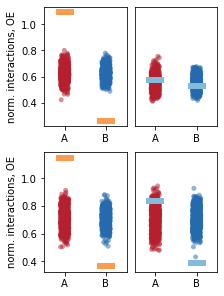

In [22]:
fx = plt.figure(figsize=(3,4),constrained_layout=True)
spx = gridspec.GridSpec(ncols=2,
                       nrows=2,
                       width_ratios=[1,1],
                       figure=fx
                      )

ax1 = fx.add_subplot(spx[0,0])
ax2 = fx.add_subplot(spx[0,1],sharey=ax1)

ax1q = fx.add_subplot(spx[1,0])
ax2q = fx.add_subplot(spx[1,1],sharey=ax1q)


grp = rnd_avg_df.groupby(["locus","region"])
vis_kwargs = dict(alpha=.5,palette=palet)
sns.stripplot(x="set", y="OE", data=grp.get_group(("allele1","parm")), ax=ax1, **vis_kwargs)
sns.stripplot(x="set", y="OE", data=grp.get_group(("allele2","parm")), ax=ax2, **vis_kwargs)

sns.stripplot(x="set", y="OE", data=grp.get_group(("allele1","qarm")), ax=ax1q, **vis_kwargs)
sns.stripplot(x="set", y="OE", data=grp.get_group(("allele2","qarm")), ax=ax2q, **vis_kwargs)


grp = obs_avg_df.groupby(["locus","region"])
vis_kwargs = dict(marker=bar_path,jitter=False,s=18,alpha=1.)
sns.stripplot(x="set", y="OE", data=grp.get_group(("allele1","parm")), ax=ax1, color=palet2[0], **vis_kwargs)
sns.stripplot(x="set", y="OE", data=grp.get_group(("allele2","parm")), ax=ax2, color=palet2[1], **vis_kwargs)

sns.stripplot(x="set", y="OE", data=grp.get_group(("allele1","qarm")), ax=ax1q, color=palet2[0], **vis_kwargs)
sns.stripplot(x="set", y="OE", data=grp.get_group(("allele2","qarm")), ax=ax2q, color=palet2[1], **vis_kwargs)

# ax1.set_ylim(2,10)
# ax2.set_ylim(2,10)
ax2.set_ylabel("")
ax2.set_xlabel("")
# ax2.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
ax2.tick_params(left=False,labelleft=False)

ax1.set_xlabel("")
# ax1.tick_params(bottom=False,labelbottom=False)
# ax1.tick_params(bottom=False,labelbottom=False)

ax2q.set_ylabel("")
ax2q.tick_params(left=False,labelleft=False)

ax1.set_ylabel("norm. interactions, OE")
ax1q.set_ylabel("norm. interactions, OE")

ax2q.set_xlabel("")
ax1q.set_xlabel("")



# # legs = plt.legend([hhh[0],hhh[1],aba],["randomized EV1","randomized EV1","calculated EV1"],frameon=False)
# # for leg in legs.legendHandles:
# #     leg.set_alpha(0.9)
# # plt.gca().set_ylabel("OE")
# # plt.gcf().set_size_inches(4,4)
plt.savefig("average_AB.pdf")

### calculate "significance"/p-value for preference of alleles with A or B compartment (by arm)...

number of randomize observations that "exceed" the preference
divided by the total number of randomized observations ...


can be done for difference of A/B preferences or for the ratio of those
`obs_avg.loc["A","OE"] - obs_avg.loc["B","OE"]`

`obs_avg.loc["A","OE"] / obs_avg.loc["B","OE"]`


/home/venevs/miniconda3/envs/newexp/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  from ipykernel import kernelapp as app


allele1 parm p-value=0.0
allele1 qarm p-value=0.0
allele2 parm p-value=0.29
allele2 qarm p-value=0.00125


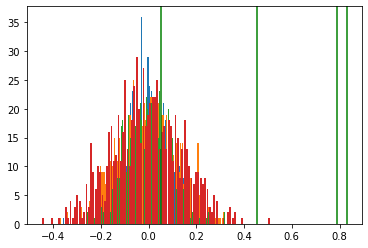

In [23]:
for _allele, _region in itertools.product(["allele1","allele2"],["parm","qarm"]):
    grp = obs_avg_df.groupby(["locus","region"])
    obs_avg = grp.get_group((_allele,_region))
    obs_avg = obs_avg.set_index("set")
    delta_obs = obs_avg.loc["A","OE"] - obs_avg.loc["B","OE"]

    grp = rnd_avg_df.groupby(["locus","region"])
    _df = grp.get_group((_allele,_region))
    A_idx = (_df["set"]=="A")
    B_idx = (_df["set"]=="B")
    delta_rnd = _df[A_idx]["OE"].values - _df[B_idx]["OE"].values
    
    num_bins = 100
    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(delta_rnd, bins=num_bins, normed=False)

    plt.bar(bin_edges[:-1],counts,width=np.diff(bin_edges)[0]*0.8)
    plt.gca().axvline(delta_obs, color="green")

    total = np.sum(counts)
    cond = np.sum(counts[bin_edges[:-1]>delta_obs])

    print(f"{_allele} {_region} p-value={cond/total}")

### trying to make an overview picture of the allele1/allel2 signal

### re-read coolers at lower resolution, and generate the average OE profile figure

lots of copy paste, but what can you do, you know ?!

In [24]:
# READ SOME COOLERS ...
binsize = 500_000
res_human = f"{int(binsize/1000)}kb"

get_cpath = lambda c,b: os.path.join(cool_path,c+f"::/resolutions/{b}")
samples["cool"] = [cooler.Cooler(get_cpath(c,binsize)) for c in samples["mcool"]]
#
# define input
samplez = "pool-2percent-highcis"
clr, = samples["cool"][samples["sample"] == samplez].values

In [25]:
chrom = "chr1"
parm = (chrom,0,74626886)
qarm = (chrom,75126886,196202544)
centro = (chrom,74626886,75126886)
balance = True

# bad_bins = None
ignore_diags = 2
theregion=parm
theregion_name="parm"

# prevent beta-actin promoter mismappings:
# (chrom,194_569_534,194_570_623)
bad_bin_regions = [(chrom,9_000_000,9_500_000),(chrom,32_270_000,32_770_000), (chrom,194_569_534,194_570_623)]
bad_bins = np.concatenate([np.arange(*clr.extent(_bb)) for _bb in bad_bin_regions])

locus_bin=72_500_000
ins_row = clr.offset((chrom,locus_bin,locus_bin+binsize))

weight_name = "weight"
weight1 = weight_name + "1"
weight2 = weight_name + "2"
transforms = {"balanced": lambda p: p["count"] * p[weight1] * p[weight2]}

In [26]:
nproc = 4
# matching regions: p-arm        pq-inter arm            chr1-wide ...
left_regions  = [(*parm,'parm'),(*parm,'parm'),("chr1",0,clr.chromsizes["chr1"],"chr1")]
right_regions = [(*parm,'parm'),(*qarm,'qarm'),("chr1",0,clr.chromsizes["chr1"],"chr1")]
# execution details
if nproc > 1:
    pool = mp.Pool(nproc)
    map_ = pool.map
else:
    map_ = map
#
exp_df_bad = expected.diagsum_asymm(clr,
                 regions1 = left_regions,
                 regions2 = right_regions,
                 transforms=transforms,
                 weight_name='weight',
                 bad_bins=bad_bins,
                 map = map_)
exp_df_bad["balanced.avg"] = exp_df_bad["balanced.sum"]/exp_df_bad["n_valid"]
exp_grp_bad = exp_df_bad.groupby(["region1","region2"])
# extract several expecteds for different regions ...
parm_exp_bad = exp_grp_bad.get_group(("parm","parm"))
pqarm_exp_bad = exp_grp_bad.get_group(("parm","qarm"))
chr1_exp_bad = exp_grp_bad.get_group(("chr1","chr1"))
#
exp_df_bad_raw = expected.diagsum_asymm(clr,
                     regions1 = left_regions,
                     regions2 = right_regions,
                     transforms={},
                     weight_name=None,
                     bad_bins=bad_bins,
                     map = map_)
exp_df_bad_raw["count.avg"] = exp_df_bad_raw["count.sum"]/exp_df_bad_raw["n_valid"]
exp_df_bad_raw_grp = exp_df_bad_raw.groupby(["region1","region2"])
# extract several expecteds for different regions ...
parm_exp_bad_raw = exp_df_bad_raw_grp.get_group(("parm","parm"))
pqarm_exp_bad_raw = exp_df_bad_raw_grp.get_group(("parm","qarm"))
chr1_exp_bad_raw = exp_df_bad_raw_grp.get_group(("chr1","chr1"))
#
pool.close()

generating appropriate `expecteds` for p and q arms, for the insertion site

In [27]:
chr1_parm = to_uscs(parm)
chr1_qarm = to_uscs(qarm)
# shape of the inter-arm heatmap ...
lo,hi = clr.extent(parm)
psize = hi-lo
lo,hi = clr.extent(qarm)
qsize = hi-lo
shape = (psize,qsize)
print(shape)

# this function that 1D exepcted to rectangular - for pq-expected
get_cr = lambda e, shape : (e[shape[0]-1::-1], e[shape[0]-1:])

# balanced expecteds ...
pqexp = numutils.LazyToeplitz(*get_cr(pqarm_exp_bad["balanced.avg"].values, shape))
pexp = numutils.LazyToeplitz(parm_exp_bad["balanced.avg"])
chr1exp = numutils.LazyToeplitz(chr1_exp_bad["balanced.avg"])

# raw expecteds ...
pqexp_raw = numutils.LazyToeplitz(*get_cr(pqarm_exp_bad_raw["count.avg"].values, shape))
pexp_raw = numutils.LazyToeplitz(parm_exp_bad_raw["count.avg"])
chr1exp_raw = numutils.LazyToeplitz(chr1_exp_bad_raw["count.avg"])

# some very stupid check:
# the following must be always true, though - as it accounts for the centromere size
assumption = np.diff(clr.extent(parm))+np.diff(clr.extent(centro))+np.diff(clr.extent(qarm))-2 == np.diff(clr.extent(chrom))
assert assumption

(150, 243)


### let's extract allele1/2-related observed, expected and weights ...

In [28]:
  
# WE ARE NOT GOING TO USE THE WEIGHTS FOR THE ALLELE1/2 ITSELF ...
# AS IT IS UNCLEAR - WHAT THEY REFLECT - ALLELE1 AND ALLELE2 AREN'T COMPARABLE
# THEMSELVES , ONLY HOW THEY INTERACT WITH THE REST OF THE GENOME ...
# wa1, = clr.bins().fetch("allele1")["weight"]
# wa2, = clr.bins().fetch("allele2")["weight"]

# allele1/2 observed - raw:
obs_r_a1_1p, = clr.matrix(balance=False).fetch("allele1",chr1_parm)
obs_r_a1_1q, = clr.matrix(balance=False).fetch("allele1",chr1_qarm)

obs_r_a2_1p, = clr.matrix(balance=False).fetch("allele2",chr1_parm)
obs_r_a2_1q, = clr.matrix(balance=False).fetch("allele2",chr1_qarm)

# balancing weights p-arm with bad_bins applied ...
wp = clr.bins().fetch(chr1_parm)[weight_name].values
lo,hi = clr.extent(chr1_parm)
bad_bins_parm = bad_bins[(bad_bins>=lo)&(bad_bins<hi)] - lo
if len(bad_bins_parm) > 0:
    wp[bad_bins_parm] = np.nan
    
# we also need to exclude 2 bins in the vicinity of the insertion site:
ignore_insertion_site = False    
if ignore_insertion_site:
    wp[ins_row-1:ins_row+2] = np.nan

# balancing weights q-arm with bad_bins masking applied ...
wq = clr.bins().fetch(chr1_qarm)[weight_name].values
lo,hi = clr.extent(chr1_qarm)
bad_bins_qarm = bad_bins[(bad_bins>=lo)&(bad_bins<hi)] - lo
if len(bad_bins_qarm) > 0:
    wq[bad_bins_qarm] = np.nan

# p-arm expected balanced al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_b_a1a2_1p = pexp[:,ins_row].flatten()
exp_b_a1a2_1p_chr1 = chr1exp[:psize,ins_row].flatten()
# p-arm expected raw al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_r_a1a2_1p = pexp_raw[:,ins_row].flatten()
exp_r_a1a2_1p_chr1 = chr1exp_raw[:psize,ins_row].flatten()

# q-arm expected balanced al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_b_a1a2_1q = pqexp[ins_row,:].flatten()
exp_b_a1a2_1q_chr1 = chr1exp[-qsize:,ins_row].flatten()
# q-arm expected balanced al1 and al2 are the same because insertion sites is really close (+/- 1kb):
exp_r_a1a2_1q = pqexp_raw[ins_row,:].flatten()
exp_r_a1a2_1q_chr1 = chr1exp_raw[-qsize:,ins_row].flatten()


In [29]:
# # main inputs:
# # compartments:
# cmp_vals = eigvec_table1["E1"].values

p_range_zoom=clr.extent(chr1_parm)
q_range_zoom=clr.extent(chr1_qarm)
sub_frac = 1.
threshold = 0.09
balanced=True
OE=True
num_permutations = 5_000
samplez = samples["sample"].values

# extract balancing weights for
# alleles 1 and 2 - they are meaningless I guess
# they only reflect - the total # of interactions
# between allele1/2 and chr1
wa2, = clr.bins().fetch("allele2")["weight"]
wa1, = clr.bins().fetch("allele1")["weight"]
# we'll try to use only allele2 balancing weight, since
# after subsampling # of pairs per allele1/2 should be
# more or less equal
if sub_frac < 0.9:
    print("Beware! Once you start subsampling allele1 data, consider adjusting wa1 ...")
    pass
    wa1 = wa2

# # now let's do a bunch of subsamplings and a bunch of randomizations to extract average OEs:
# obs_average = []
# rnd_average = []

d1 = {}
d2 = {}
# p-arm data:
d1["parm"] = np.random.binomial(obs_r_a1_1p,sub_frac).T
d2["parm"] = obs_r_a2_1p
if balanced:
    d1["parm"] = d1["parm"] * wp * wa1
    d2["parm"] = d2["parm"] * wp * wa2
    ep12 = exp_b_a1a2_1p
    epc12 = exp_b_a1a2_1p_chr1
else:
    ep12 = exp_r_a1a2_1p
    epc12 = exp_r_a1a2_1p_chr1
if OE:
    # only arm level expected ...
    d1["parm"] = d1["parm"] / ep12
    d2["parm"] = d2["parm"] / ep12
# q-arm data:
d1["qarm"] = np.random.binomial(obs_r_a1_1q,sub_frac).T
d2["qarm"] = obs_r_a2_1q
if balanced:
    d1["qarm"] = d1["qarm"] * wq * wa1
    d2["qarm"] = d2["qarm"] * wq * wa2
    epq12 = exp_b_a1a2_1q
    epqc12 = exp_b_a1a2_1q_chr1
else:
    epq12 = exp_r_a1a2_1q
    epqc12 = exp_r_a1a2_1q_chr1
if OE:
    # only arm level expected ...
    d1["qarm"] = d1["qarm"] / epq12
    d2["qarm"] = d2["qarm"] / epq12


/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:59: RuntimeWarning: invalid value encountered in less_equal
  ax.fill_between(x,y0,y,where=(y<=level),color = color_less)
/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:60: RuntimeWarning: invalid value encountered in greater
  ax.fill_between(x,y0,y,where=(y>level),color = color_more)


Text(0, 0.5, 'norm. interactions, OE')

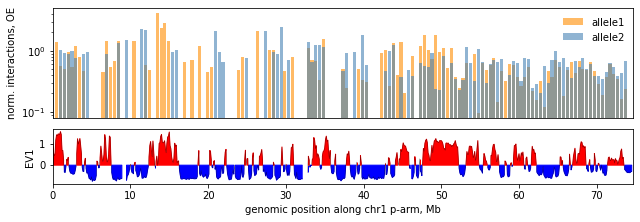

In [30]:
# visualize compartments:
f = plt.figure(figsize=(23*psize/(psize+qsize),3),constrained_layout=True)
sp = gridspec.GridSpec(ncols=1,
                       nrows=2,
                       height_ratios=[2,1],
                       figure=f
                      )

axp = f.add_subplot(sp[0])
axpc = f.add_subplot(sp[1])#,sharex=axp)
# axprt = f.add_subplot(sp[2])#,sharex=axp)
# axpcb = f.add_subplot(sp[1,0])
# axprtb = f.add_subplot(sp[2,0])

axp.tick_params(bottom=False,labelbottom=False)
# axpc.tick_params(bottom=False,labelbottom=False)


clr = samples["cool"][0]
rtdf = binned_rt["value_rt"].reset_index(drop=True).values
cmp_vals = eigvec_table1["E1"].values

# p_range_zoom = clr.extent(chr1_parm)
log=True
# balanced=True
# OE=True
# samplez = samples["sample"].values[0]
# sub_frac = 0.65

# # we are switching samples inside interactively ...
# clr, = samples["cool"][samples["sample"] == samplez].values
# # extract balancing weights for
# # alleles 1 and 2 - they are meaningless I guess
# # they only reflect - the total # of interactions
# # between allele1/2 and chr1

# # adjust everything to the visible region:
xp = range(*p_range_zoom)
# compartments:
cmpp = cmp_vals[slice(*p_range_zoom)]
rtpp = rtdf[slice(*p_range_zoom)]

axp.bar(xp, d1["parm"][slice(*p_range_zoom)], alpha=0.6, color="darkorange", label="allele1")
axp.bar(xp, d2["parm"][slice(*p_range_zoom)], alpha=0.6,  color="steelblue", label="allele2")
axp.set_xlim(*p_range_zoom)
axp.legend(loc="upper right",frameon=False)

if log:
    axp.set_yscale("log")

fillcolor_compartment_style(cmp_vals, axpc, bin_range=clr100.extent(chr1_parm) )
# fillcolor_compartment_style(rtdf, axprt, bin_range=clr100.extent(chr1_parm) )

axpc.set_xlim(clr100.extent(chr1_parm))
# axprt.set_xlim(clr100.extent(chr1_parm))

from matplotlib import ticker
bin_to_mb = ticker.FuncFormatter(lambda x,pos: f"{int(x*100_000/1_000_000)}")
axpc.xaxis.set_major_formatter(bin_to_mb)
axpc.set_xlabel("genomic position along chr1 p-arm, Mb")

pylim = axp.get_ylim()
pcylim = axpc.get_ylim()


axpc.set_ylabel("EV1")
axp.set_ylabel("norm. interactions, OE")

# plt.savefig("main_parm.pdf")

/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:59: RuntimeWarning: invalid value encountered in less_equal
  ax.fill_between(x,y0,y,where=(y<=level),color = color_less)
/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:60: RuntimeWarning: invalid value encountered in greater
  ax.fill_between(x,y0,y,where=(y>level),color = color_more)


Text(0, 0.5, 'norm. interactions, OE')

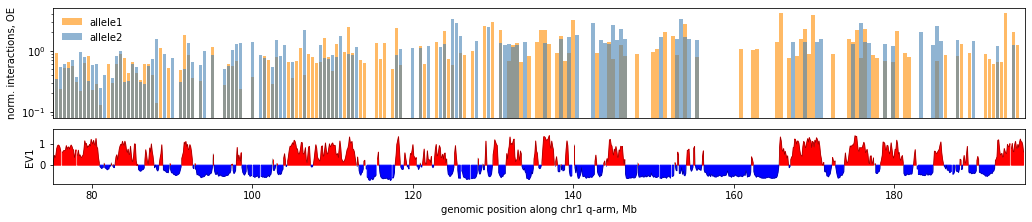

In [31]:
# visualize compartments:
f = plt.figure(figsize=(23*qsize/(psize+qsize),3),constrained_layout=True)
sp = gridspec.GridSpec(ncols=1,
                       nrows=2,
                       height_ratios=[2,1],
                       figure=f
                      )

axq = f.add_subplot(sp[0])
axqc = f.add_subplot(sp[1])#,sharex=axq)

axq.tick_params(bottom=False,labelbottom=False)
# axqc.tick_params(bottom=False,labelbottom=False)


clr = samples["cool"][0]
cmp_vals = eigvec_table1["E1"].values

q_range_zoom = clr.extent(chr1_qarm)
# log=True
# balanced=True
# OE=True
# samplez = samples["sample"].values[0]
# sub_frac = 0.65

# # we are switching samples inside interactively ...
# clr, = samples["cool"][samples["sample"] == samplez].values
# # extract balancing weights for
# # alleles 1 and 2 - they are meaningless I guess
# # they only reflect - the total # of interactions
# # between allele1/2 and chr1

# # adjust everything to the visible region:
xq = range(*q_range_zoom)
# compartments:
cmpq = cmp_vals[slice(*q_range_zoom)]
q_range_zoom_rel = [_-clr.offset(chr1_qarm) for _ in q_range_zoom]
q_range_zoom_rel_100 = [_-clr100.offset(chr1_qarm) for _ in clr100.extent(chr1_qarm)]



axq.bar(xq, d1["qarm"][slice(*q_range_zoom_rel)], alpha=0.6, color="darkorange", label="allele1")
axq.bar(xq, d2["qarm"][slice(*q_range_zoom_rel)], alpha=0.6,  color="steelblue", label="allele2")
axq.set_xlim(*q_range_zoom)
axq.legend(loc="upper left",frameon=False)

if log:
    axq.set_yscale("log")

fillcolor_compartment_style(cmp_vals, axqc, bin_range=clr100.extent(chr1_qarm) )
# fillcolor_compartment_style(rtdf, axqrt, bin_range=clr100.extent(chr1_parm) )

axqc.set_xlim(clr100.extent(chr1_qarm))
# axqrt.set_xlim(clr100.extent(chr1_parm))

axq.set_ylim(pylim)
axqc.set_ylim(pcylim)


bin_to_mb = ticker.FuncFormatter(lambda x,pos: f"{int(x*100_000/1_000_000)}")
axqc.xaxis.set_major_formatter(bin_to_mb)
axqc.set_xlabel("genomic position along chr1 q-arm, Mb")

axqc.set_ylabel("EV1")
axq.set_ylabel("norm. interactions, OE")

# plt.savefig("main_qarm.pdf")